In [2]:
import scipy.io 
import numpy as np 
import matplotlib.pyplot as plt 
import alphashape
from scipy.interpolate import interp1d
from scipy.spatial import ConvexHull
from scipy.optimize import curve_fit
from shapely.geometry import Polygon, MultiPolygon
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import warnings
from collections import defaultdict
from tqdm import tqdm
from scipy.interpolate import interp1d

In [3]:
#file_path = r'C:\Users\josep\Desktop\Summer Research Project\white_pixels.mat'
data = scipy.io.loadmat('C:\\Users\josep\Desktop\Summer Research Project\july6_processededges.mat') 

# Extract the frames 
processed_edges = data['processedEdges'] 

In [4]:
processed_edges[0,0].shape

(1080, 1721)

In [5]:
no_frames = processed_edges.shape[1]
no_frames

727

# 1) Input Manually

## 1.1) Halfway Line

In [8]:
half_line_y = 587.5 
# at what value do you define the halfway line between the reflection 

In [116]:
i = 22
# test a random frame

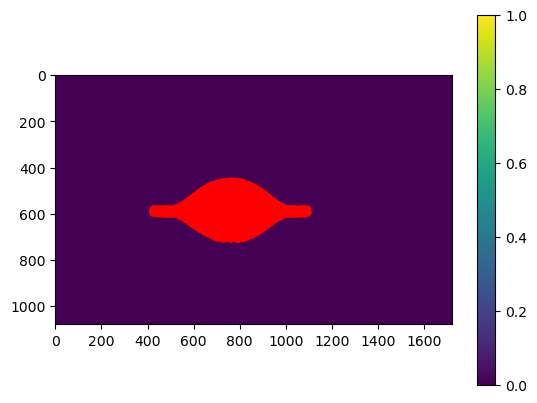

In [118]:
# Extract the 2D array
data = processed_edges[0, i]

# Find indices where values are greater than 0.8
y, x = np.where(data > 0.8)

# Plot the 2D array
plt.imshow(data, cmap='viridis')
plt.colorbar()

# Overlay the points
plt.scatter(x, y, color='red', s=2)

# Show the plot
plt.show()

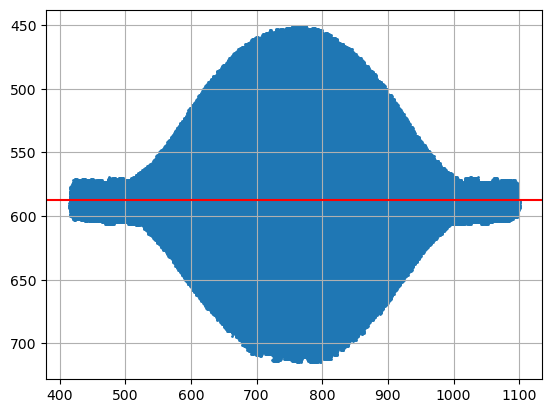

In [120]:
plt.figure()
plt.scatter(x, y, s = 1)
plt.grid(True)
plt.gca().invert_yaxis()

# Draw the horizontal line at 230
plt.axhline(y=half_line_y, color='r', linestyle='-')


#plt.ylim(599,580)
#plt.xlim(520, 720)
plt.show()

In [85]:
len(x) < 5000

False

In [87]:
587 not in y

True

# 2) Define Functions

In [25]:
def plot_extreme_x_points(x_edge, y_edge, target_y):
    """
    Plots the smallest and largest x values at target_y along with the other points.
    
    Parameters:
    x_edge (list): List of x coordinates.
    y_edge (list): List of y coordinates.
    target_y (int or float): The y value to filter the x values.
    """
    # Separate points at target_y and other points
    x_at_target_y = [x_edge[i] for i in range(len(y_edge)) if y_edge[i] == target_y]
    x_other = [x_edge[i] for i in range(len(y_edge)) if y_edge[i] != target_y]
    y_other = [y_edge[i] for i in range(len(y_edge)) if y_edge[i] != target_y]

    # Find the smallest and largest x values at target_y
    if x_at_target_y:  # Ensure there's at least one point at target_y
        x_min = min(x_at_target_y)
        x_max = max(x_at_target_y)

        # Create new lists for plotting the points at target_y
        x_filtered = [x_min, x_max]
        y_filtered = [target_y, target_y]

    new_x = np.concatenate((x_filtered, x_other))
    new_y = np.concatenate((y_filtered, y_other))

    return new_x, new_y

# 3) Perform Loop

## 3.1) Left Angle

In [32]:
len(x)

3780

In [46]:
angles_list = []
i_left_list = []

for i in tqdm(range(no_frames)):

#for i in tqdm([200]):
    # Extract the 2D array
    data = processed_edges[0, i]

    # Find indices where values are greater than 0.8
    y, x = np.where(data > 0.8)

    if len(x) < 5000 or 587 not in y:
        pass 

    else:
        # Only consider upper half 
        x_upper = x[y <= half_line_y]
        y_upper = y[y <= half_line_y]

        # Only perform for the left side 
        quarter_point = (-np.min(x_upper) + np.max(x_upper)) / 4 + np.min(x_upper)
        quarter_mask = [x_upper <= quarter_point][0]

        x_quarter = x_upper[quarter_mask]
        y_quarter = y_upper[quarter_mask]

        x_filtered = x_quarter[y_quarter <= half_line_y]
        y_filtered = y_quarter[y_quarter <= half_line_y]

        # Create points array
        points = np.vstack((x_filtered, y_filtered)).T

        # Compute the alpha shape with a suitable alpha value
        alpha = 0.1  #
        alpha_shape = alphashape.alphashape(points, alpha)
        if isinstance(alpha_shape, Polygon):
            x_edge, y_edge = alpha_shape.exterior.xy
        elif isinstance(alpha_shape, MultiPolygon):
            for poly in alpha_shape:
                x_edge, y_edge = poly.exterior.xy

        x_main_edge, y_main_edge = plot_extreme_x_points(x_edge, y_edge, 587)
        mask_middle = np.where( np.isclose(x_main_edge, quarter_point, atol= 1.5) )

        #Get all indices
        all_indices = np.arange(x_main_edge.shape[0])
        
        # Get indices that are not in mask_middle
        ind_not_middle = np.setdiff1d(all_indices, mask_middle)
        
        x_half = x_main_edge[ind_not_middle]
        y_half = y_main_edge[ind_not_middle]

        y_to_x = defaultdict(list)
        for x_v, y_v in zip(x_half, y_half):
            y_to_x[y_v].append(x_v)
        
        unique_y = np.array(sorted(y_to_x.keys()))
        unique_x = np.array([np.mean(y_to_x[y_v]) for y_v in unique_y])

        no_of_points = 20

        x_edge_points = unique_x[-no_of_points:]
        y_edge_points = unique_y[-no_of_points:]

        # Find the index of the maximum y value
        max_y_index = np.argmax(y_edge_points)
        max_x_point = x_edge_points[max_y_index]
        max_y_point = y_edge_points[max_y_index]

        '''Perform Iterative fitting for polynomials with degrees between 0 and 12'''

        # Initialize variables to store the best degree and its corresponding RMSE
        best_degree = 0
        best_rmse = float('inf')
        best_poly = None
        
        # Iterate through polynomial degrees from 0 to 12
        for degree in range(13):
        
                # Suppress the RankWarning for poorly conditioned polynomial fit
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', np.RankWarning)
                # Fit a polynomial to the data points
                coeffs = np.polyfit(y_edge_points, x_edge_points, degree)
            
            # Adjust the polynomial to pass through the (max_y_point, max_x_point)
            poly = np.poly1d(coeffs)
        
            # Evaluate the polynomial at the max_y_point
            x_at_max_y = poly(max_y_point)
        
            # Calculate the adjustment needed for the constant term
            adjustment = max_x_point - x_at_max_y
        
            # Create the adjusted polynomial
            coeffs[-1] += adjustment
            poly_adjusted = np.poly1d(coeffs)
        
            # Calculate the RMSE for the current polynomial
            x_pred = poly_adjusted(y_edge_points)
            rmse = np.sqrt(mean_squared_error(x_edge_points, x_pred))
        
            # Update the best degree and polynomial if the current RMSE is lower
            if rmse < best_rmse:
                best_rmse = rmse
                best_degree = degree
                best_poly = poly_adjusted

        # Create the fitted polynomial line using the best polynomial
        y_fit = np.linspace(np.min(y_edge_points), np.max(y_edge_points), 10)
        x_fit = best_poly(y_fit)

        index_min_x = np.argmax(y_fit)
        y_at_min_x = y_fit[index_min_x]

        # calculate the derivative at the point
        if index_min_x==0:
            dx_new = x_fit[0]-x_fit[1]
        
        if index_min_x > 0:
            dx_new = x_fit[index_min_x-1] - x_fit[index_min_x]
        
        if dx_new>0:
            dx = -dx_new
        if dx_new<0:
            dx = np.abs(dx_new)
        
        dy_dx = np.gradient(y_fit, dx)
        slope_at_min_x1 = dy_dx[index_min_x]

        angle_tangent_degrees_left = np.degrees(np.arctan(slope_at_min_x1))
        # Measure angle on right side of interpolation 
        
        if angle_tangent_degrees_left<0:
            angle = np.abs(angle_tangent_degrees_left)
        
        if angle_tangent_degrees_left>0:
            angle = 180 - angle_tangent_degrees_left

        angles_list.append(angle)
        i_left_list.append(i)

100%|██████████| 727/727 [15:42<00:00,  1.30s/it]


In [54]:
i_left = np.array(i_left_list)

In [56]:
angle_left = np.array(angles_list)
angle_left

array([100.91561566, 133.64453016,  76.70998101, 159.50199702,
       137.97450401,  79.46882001, 152.58225883, 105.18203497,
        99.81399269, 113.25814118, 100.83457656,  82.23807605,
        88.24421545,  88.09843944,  80.08830616,  24.42726326,
        26.17898241,  23.5438929 ,  57.25777511,  33.13155293,
        39.68512333,  13.25950252,  11.51670319,  16.10212474,
        13.04592779,  12.66291235,  12.27699226,  11.49155439,
        10.05462979,  10.36682221,  11.00116008,  11.41302431,
        10.2603145 ,   9.5267921 ,   7.75792197,   7.55540871,
         8.78092982,   8.51804077,   7.88510858,   6.9415971 ,
         7.85846574,  12.38529561,  15.78272142,  12.36295875,
        10.07008982,   9.18500271,   9.78388407,   8.68552829,
         7.12194818,   6.60996351,   4.88709571,   6.4425006 ,
         7.50761866,  15.28864644,  17.12455853,  14.513606  ,
        16.39141794,  14.7760016 ,  16.02765142,  17.10277218,
        20.92453895,  29.97057388,  30.74305026,  25.89

In [58]:
angle_left.shape

(681,)

In [60]:
no_frames

727

In [64]:
data1 = np.column_stack((i_left, angle_left))
file_path = r"C:\Users\josep\Desktop\Summer Research Project\Left_angel_model2_july6.txt"
#np.savetxt(file_path, data1, delimiter='\t', header='i\tTheta')

In [72]:
file_path = r"C:\Users\josep\Desktop\Summer Research Project\Left_angel_model2_july6.txt"

# Load data
loaded_data = np.loadtxt(file_path, delimiter='\t', skiprows=1)  # Skip header row

# columns
i_left = loaded_data[:, 0]
theta_left = loaded_data[:, 1]

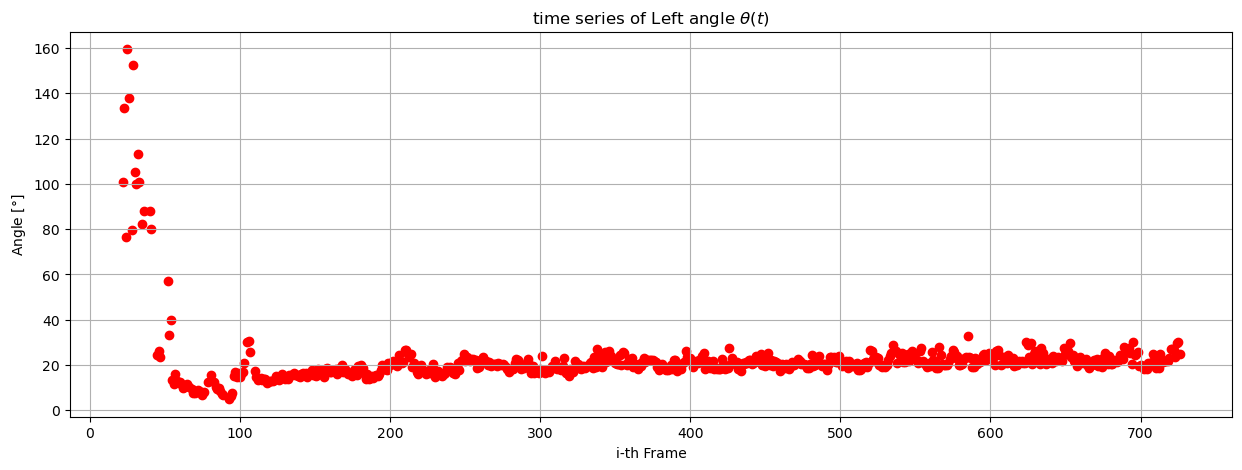

In [74]:
plt.figure(figsize=(15,5))
plt.scatter(i_left, theta_left, color = 'red')

plt.xlabel("i-th Frame")
plt.ylabel("Angle [$\degree$]")
plt.title("time series of Left angle $\\theta(t)$")
plt.grid(True)

## 3.2) Right Angle

In [89]:
angles_list = []
i_right_list = []

for i in tqdm(range(no_frames)):
    # Extract the 2D array
    data = processed_edges[0, i]

    # Find indices where values are greater than 0.8
    y, x = np.where(data > 0.8)

    if len(x) < 5000 or 587 not in y:
        pass 

    else:
        # Only consider upper half 
        x_upper = x[y <= half_line_y]
        y_upper = y[y <= half_line_y]

        # Only perform for the left side 
        quarter_point = -(-np.min(x_upper) + np.max(x_upper)) / 4 + np.max(x_upper)
        quarter_mask = [x_upper >= quarter_point][0]

        x_quarter = x_upper[quarter_mask]
        y_quarter = y_upper[quarter_mask]

        x_filtered = x_quarter[y_quarter <= half_line_y]
        y_filtered = y_quarter[y_quarter <= half_line_y]

        # Create points array
        points = np.vstack((x_filtered, y_filtered)).T

        # Compute the alpha shape with a suitable alpha value
        alpha = 0.1  #
        alpha_shape = alphashape.alphashape(points, alpha)
        if isinstance(alpha_shape, Polygon):
            x_edge, y_edge = alpha_shape.exterior.xy
        elif isinstance(alpha_shape, MultiPolygon):
            for poly in alpha_shape:
                x_edge, y_edge = poly.exterior.xy

        x_main_edge, y_main_edge = plot_extreme_x_points(x_edge, y_edge, 587)
        mask_middle = np.where( np.isclose(x_main_edge, quarter_point, atol= 1.5) )

        #Get all indices
        all_indices = np.arange(x_main_edge.shape[0])
        
        # Get indices that are not in mask_middle
        ind_not_middle = np.setdiff1d(all_indices, mask_middle)
        
        x_half = x_main_edge[ind_not_middle]
        y_half = y_main_edge[ind_not_middle]

        y_to_x = defaultdict(list)
        for x_v, y_v in zip(x_half, y_half):
            y_to_x[y_v].append(x_v)
        
        unique_y = np.array(sorted(y_to_x.keys()))
        unique_x = np.array([np.mean(y_to_x[y_v]) for y_v in unique_y])

        no_of_points = 20

        x_edge_points = unique_x[-no_of_points:]
        y_edge_points = unique_y[-no_of_points:]

        # Find the index of the maximum y value
        max_y_index = np.argmax(y_edge_points)
        max_x_point = x_edge_points[max_y_index]
        max_y_point = y_edge_points[max_y_index]

        '''Perform Iterative fitting for polynomials with degrees between 0 and 12'''

        # Initialize variables to store the best degree and its corresponding RMSE
        best_degree = 0
        best_rmse = float('inf')
        best_poly = None
        
        # Iterate through polynomial degrees from 0 to 12
        for degree in range(13):
        
                # Suppress the RankWarning for poorly conditioned polynomial fit
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', np.RankWarning)
                # Fit a polynomial to the data points
                coeffs = np.polyfit(y_edge_points, x_edge_points, degree)
            
            # Adjust the polynomial to pass through the (max_y_point, max_x_point)
            poly = np.poly1d(coeffs)
        
            # Evaluate the polynomial at the max_y_point
            x_at_max_y = poly(max_y_point)
        
            # Calculate the adjustment needed for the constant term
            adjustment = max_x_point - x_at_max_y
        
            # Create the adjusted polynomial
            coeffs[-1] += adjustment
            poly_adjusted = np.poly1d(coeffs)
        
            # Calculate the RMSE for the current polynomial
            x_pred = poly_adjusted(y_edge_points)
            rmse = np.sqrt(mean_squared_error(x_edge_points, x_pred))
        
            # Update the best degree and polynomial if the current RMSE is lower
            if rmse < best_rmse:
                best_rmse = rmse
                best_degree = degree
                best_poly = poly_adjusted

        # Create the fitted polynomial line using the best polynomial
        y_fit = np.linspace(np.min(y_edge_points), np.max(y_edge_points), 10)
        x_fit = best_poly(y_fit)

        index_min_x = np.argmax(y_fit)
        y_at_min_x = y_fit[index_min_x]

        # calculate the derivative at the point
        if index_min_x==0:
            dx_new = x_fit[0]-x_fit[1]
        
        if index_min_x > 0:
            dx_new = x_fit[index_min_x-1] - x_fit[index_min_x]
        
        if dx_new>0:
            dx = -dx_new
        if dx_new<0:
            dx = np.abs(dx_new)
        
        dy_dx = np.gradient(y_fit, dx)
        slope_at_min_x1 = dy_dx[index_min_x]

        angle_tangent_degrees_right  = np.degrees(np.arctan(slope_at_min_x1))
        # Measure angle on right side of interpolation 
        
        if angle_tangent_degrees_right < 0:
            angle = 180 + angle_tangent_degrees_right
        
        if angle_tangent_degrees_right > 0:
            angle = angle_tangent_degrees_right

        angles_list.append(angle)
        i_right_list.append(i)

100%|██████████| 727/727 [11:37<00:00,  1.04it/s]


In [97]:
i_right = np.array(i_right_list)

In [99]:
angle_right = np.array(angles_list)
angle_right

array([140.17686798, 102.01448838,  70.040162  , 139.01628908,
       147.65988969,  99.10161617, 125.72168601,  96.83774096,
       108.54313037, 106.90307406,  77.76326633,  79.39521784,
        83.56324569,  59.68326626,  67.43818437,  25.64091092,
        32.27522883,  36.23250238,  13.81658954,  14.96195035,
        13.92826232,  11.23643081,  12.80675185,  11.71818457,
        10.26879557,  10.09874126,  10.18885502,  11.8729195 ,
        10.80869943,  12.53436428,  13.49645888,  13.94281839,
         7.05017189,  12.3537877 ,   9.21305121,   7.56231896,
         7.42456229,   8.49615243,  10.42434203,   9.89307498,
         8.57943445,   7.96983128,  10.5317013 ,  11.75016206,
        12.0274143 ,   9.79990161,   8.88606908,   7.19529059,
         7.5564853 ,   7.60638952,   4.11018958,   4.65746467,
         5.4507275 ,   9.47692683,  10.98429374,  10.8877498 ,
        14.50953442,  13.92213903,  13.83813297,  13.25143104,
        15.2189259 ,  11.42463821,  10.42971507,   9.64

In [101]:
data1 = np.column_stack((i_right, angle_right))
file_path = r"C:\Users\josep\Desktop\Summer Research Project\Right_angel_model2_july6.txt"
#np.savetxt(file_path, data1, delimiter='\t', header='i\tTheta')

In [103]:
file_path = r"C:\Users\josep\Desktop\Summer Research Project\Right_angel_model2_july6.txt"

# Load data
loaded_data = np.loadtxt(file_path, delimiter='\t', skiprows=1)  # Skip header row

# columns
i_right = loaded_data[:, 0]
theta_right = loaded_data[:, 1]

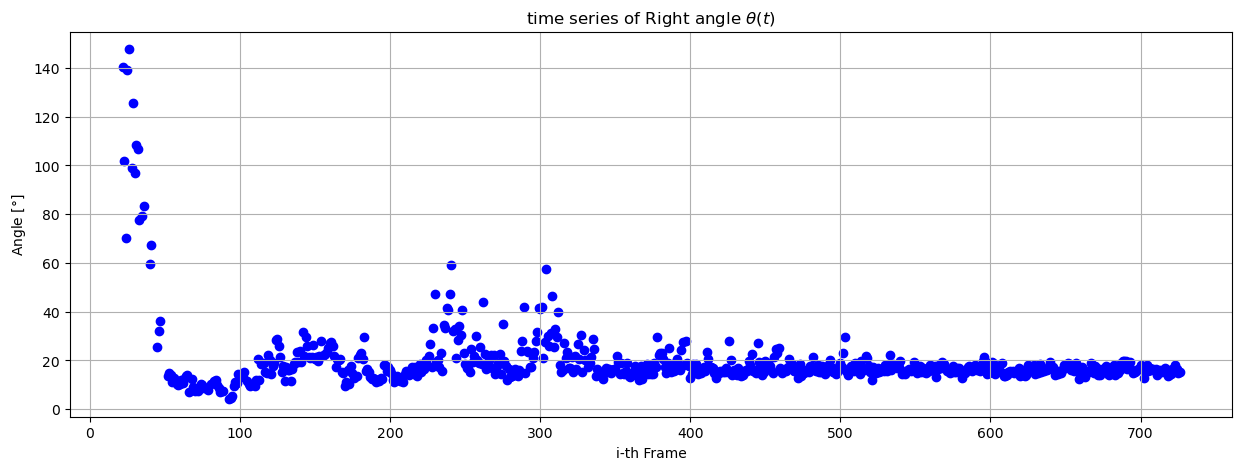

In [105]:
plt.figure(figsize=(15,5))
plt.scatter(i_right, theta_right, color = 'blue')

plt.xlabel("i-th Frame")
plt.ylabel("Angle [$\degree$]")
plt.title("time series of Right angle $\\theta(t)$")
plt.grid(True)

# 3.3) Compare 

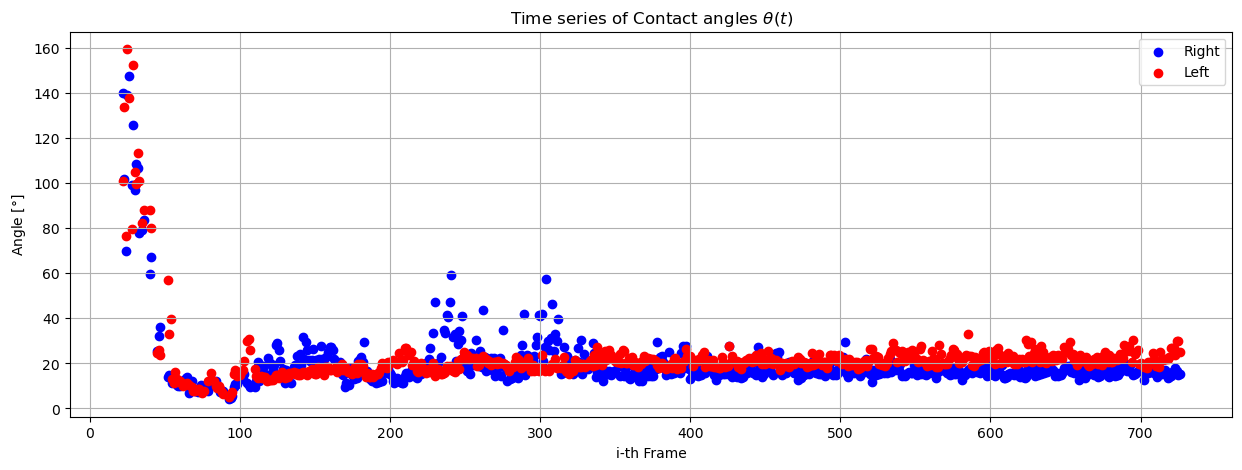

In [108]:
plt.figure(figsize=(15,5))
plt.scatter(i_right, theta_right, label = 'Right', color = 'blue')
plt.scatter(i_left, theta_left, label = 'Left', color = 'red')

plt.xlabel("i-th Frame")
plt.ylabel("Angle [$\degree$]")
plt.title("Time series of Contact angles $\\theta (t)$")
plt.grid(True)
plt.legend()

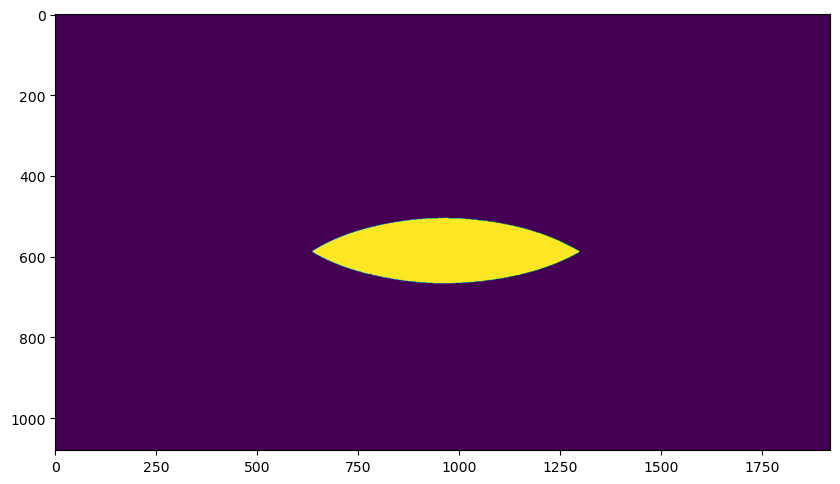

In [60]:
i = 200
plt.figure(figsize=(10,10))
plt.imshow(processed_edges[0, i], cmap='viridis')  

#plt.ylim(230, 0)

#plt.colorbar()  
plt.show()